In [28]:
#Data Manipulation
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import matplotlib.pyplot as plt
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}

In [30]:
def addNLags(df, lags_list):
    lag_df= df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 24).fillna(0)

def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()


def calculate_metrics(y_true, y_pred):    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE (Root Mean Squared Error)
    rmse = root_mean_squared_error(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    # MDAPE (Median Absolute Percentage Error)
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mae, rmse, mape, mdape

In [99]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Demanda_kWh"]] \
    .rename(columns={'Date': 'ds',
                     'Demanda_kWh': 'y'})
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()

In [100]:
%%time
model = Prophet()
model.fit(train)

23:08:43 - cmdstanpy - INFO - Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 93.8 ms
Wall time: 2.44 s


In [101]:
# Generar fechas futuras
future_dates = model.make_future_dataframe(periods=len(test), freq='60min')
# Realizar predicciones
forecast = model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-02 00:00:00,7.133045,-1.895118,10.837265,7.133045,7.133045,-2.869723,-2.869723,-2.869723,-3.183292,-3.183292,-3.183292,0.313569,0.313569,0.313569,0.0,0.0,0.0,4.263322
1,2022-07-02 01:00:00,7.131432,-1.498143,11.043082,7.131432,7.131432,-2.613386,-2.613386,-2.613386,-2.968969,-2.968969,-2.968969,0.355583,0.355583,0.355583,0.0,0.0,0.0,4.518046
2,2022-07-02 02:00:00,7.129819,-1.289839,10.878975,7.129819,7.129819,-2.453504,-2.453504,-2.453504,-2.845955,-2.845955,-2.845955,0.392452,0.392452,0.392452,0.0,0.0,0.0,4.676315
3,2022-07-02 03:00:00,7.128206,-1.543351,10.701754,7.128206,7.128206,-2.443329,-2.443329,-2.443329,-2.866794,-2.866794,-2.866794,0.423465,0.423465,0.423465,0.0,0.0,0.0,4.684877
4,2022-07-02 04:00:00,7.126593,-1.392404,11.349963,7.126593,7.126593,-2.321419,-2.321419,-2.321419,-2.769396,-2.769396,-2.769396,0.447977,0.447977,0.447977,0.0,0.0,0.0,4.805174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12042,2023-11-24 20:00:00,9.272759,4.574224,18.467100,6.164038,12.112351,2.380734,2.380734,2.380734,2.270754,2.270754,2.270754,0.109980,0.109980,0.109980,0.0,0.0,0.0,11.653493
12043,2023-11-24 21:00:00,9.273553,2.136645,16.962995,6.163167,12.115593,0.003730,0.003730,0.003730,-0.160791,-0.160791,-0.160791,0.164520,0.164520,0.164520,0.0,0.0,0.0,9.277282
12044,2023-11-24 22:00:00,9.274346,-0.058663,14.482399,6.162296,12.117513,-1.892431,-1.892431,-1.892431,-2.109640,-2.109640,-2.109640,0.217209,0.217209,0.217209,0.0,0.0,0.0,7.381915
12045,2023-11-24 23:00:00,9.275139,-1.106289,13.532283,6.161424,12.118362,-2.800838,-2.800838,-2.800838,-3.068011,-3.068011,-3.068011,0.267173,0.267173,0.267173,0.0,0.0,0.0,6.474301


c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



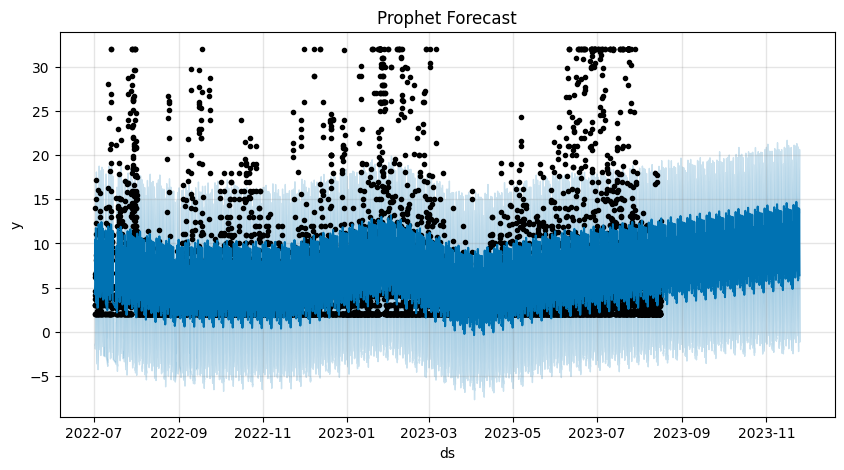

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast, ax=ax)
ax.set_title("Prophet Forecast")
plt.show()

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

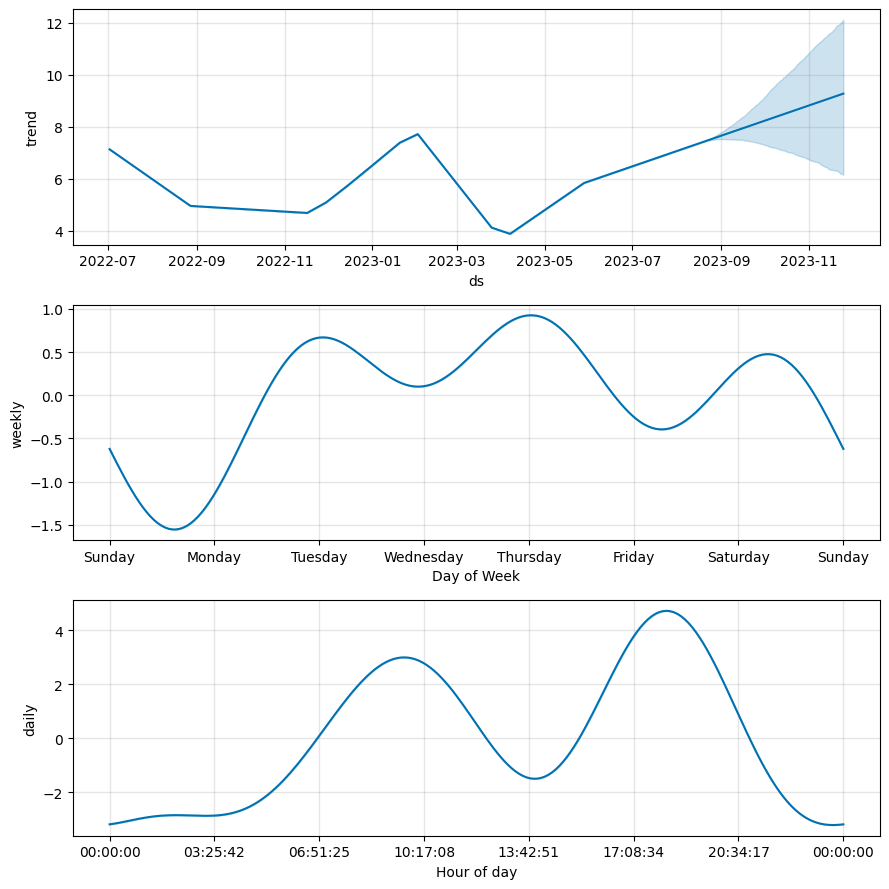

In [103]:
model.plot_components(forecast)
plt.show()

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



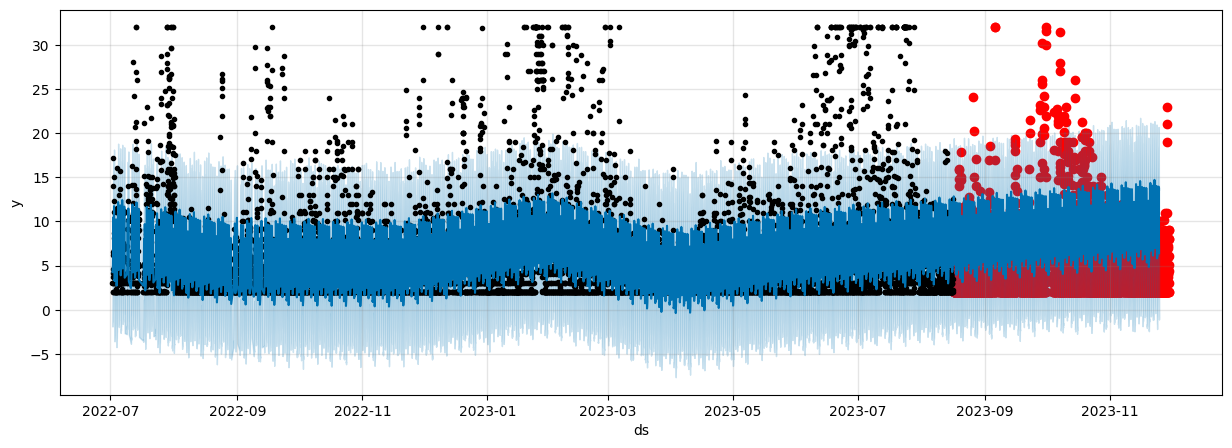

In [104]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test["ds"], test['y'], color='r')
fig = model.plot(forecast, ax=ax)

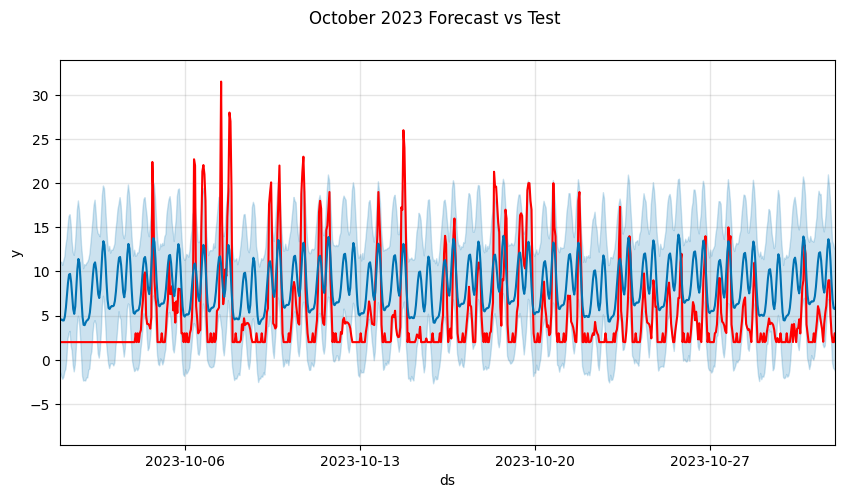

In [105]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(test["ds"], test['y'], color='r', label='Test')
fig = model.plot(forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2023-10-01 00:00:00'), pd.Timestamp('2023-11-01 00:00:00'))
plot = plt.suptitle('October 2023 Forecast vs Test')

In [106]:
predictions = forecast['yhat'].values[:len(test)]

In [107]:
mae, rmse, mape, mdape = calculate_metrics(test['y'], predictions)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

MAE: 3.814269541912404, RMSE: 5.191350304204305, MAPE: 105.76732138967755, MdAPE: 75.39958336500652


### Holidays

In [214]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)

df = df[["Date", "Demanda_kWh", "isHoliday", 
         "temperature_2m_C", "shortwave_radiation_W/m2",
         "diffuse_radiation_W/m2"]] \
    .rename(columns={'Date': 'ds',
                     'Demanda_kWh': 'y',
                     'temperature_2m_C': 'regressor1',
                     'shortwave_radiation_W/m2': 'regressor2',
                     'diffuse_radiation_W/m2': 'regressor3'})

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()
holidays_df = df[df["isHoliday"]].copy()
df = df.drop(columns=["isHoliday"], axis=1)
holidays_prophet = pd.DataFrame({
    'holiday': 'Holiday',
    'ds': holidays_df['ds'],
    'lower_window': 0,
    'upper_window': 1
})

In [215]:
%%time
model = Prophet()
model.add_regressor('regressor1')
model.add_regressor('regressor2')
model.add_regressor('regressor3')

model.fit(train)

23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 172 ms
Wall time: 2.52 s


In [216]:
# Generar fechas futuras
future_dates = model.make_future_dataframe(periods=len(test), freq='60min')[:-1]
future_dates['regressor1'] = df['regressor1']
future_dates['regressor2'] = df['regressor2']
future_dates['regressor3'] = df['regressor3']

# Realizar predicciones
forecast = model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,regressor3,regressor3_lower,regressor3_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-02 00:00:00,1.876577,0.837911,2.051897,1.876577,1.876577,-0.411817,-0.411817,-0.411817,-0.472496,...,0.059544,0.059544,0.059544,0.055683,0.055683,0.055683,0.0,0.0,0.0,1.464760
1,2022-07-02 01:00:00,1.876316,0.852587,2.077636,1.876316,1.876316,-0.389661,-0.389661,-0.389661,-0.452925,...,0.059544,0.059544,0.059544,0.060100,0.060100,0.060100,0.0,0.0,0.0,1.486655
2,2022-07-02 02:00:00,1.876055,0.876666,2.117574,1.876055,1.876055,-0.375257,-0.375257,-0.375257,-0.443084,...,0.059544,0.059544,0.059544,0.063846,0.063846,0.063846,0.0,0.0,0.0,1.500798
3,2022-07-02 03:00:00,1.875794,0.923639,2.127024,1.875794,1.875794,-0.371870,-0.371870,-0.371870,-0.442767,...,0.059544,0.059544,0.059544,0.066835,0.066835,0.066835,0.0,0.0,0.0,1.503924
4,2022-07-02 04:00:00,1.875533,0.948091,2.122420,1.875533,1.875533,-0.328672,-0.328672,-0.328672,-0.399553,...,0.056557,0.056557,0.056557,0.068990,0.068990,0.068990,0.0,0.0,0.0,1.546861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12041,2023-11-24 19:00:00,1.860047,1.617274,3.010775,1.512690,2.193067,0.473296,0.473296,0.473296,0.458347,...,0.059544,0.059544,0.059544,0.026884,0.026884,0.026884,0.0,0.0,0.0,2.333344
12042,2023-11-24 20:00:00,1.860084,1.463013,2.816559,1.512344,2.193281,0.278240,0.278240,0.278240,0.257069,...,0.059544,0.059544,0.059544,0.033198,0.033198,0.033198,0.0,0.0,0.0,2.138324
12043,2023-11-24 21:00:00,1.860120,1.155065,2.592245,1.511999,2.193496,-0.008900,-0.008900,-0.008900,-0.037088,...,0.059544,0.059544,0.059544,0.039340,0.039340,0.039340,0.0,0.0,0.0,1.851221
12044,2023-11-24 22:00:00,1.860157,0.885196,2.288352,1.511653,2.193710,-0.263369,-0.263369,-0.263369,-0.298564,...,0.059544,0.059544,0.059544,0.045204,0.045204,0.045204,0.0,0.0,0.0,1.596788


In [217]:
future_dates

,ds,regressor1,regressor2,regressor3
0,2022-07-02 00:00:00,20.259000,0.00,0.0
1,2022-07-02 01:00:00,19.277750,0.00,0.0
2,2022-07-02 02:00:00,19.715250,0.00,0.0
3,2022-07-02 03:00:00,19.759000,0.00,0.0
4,2022-07-02 04:00:00,19.609001,3.75,3.0
...,...,...,...,...
12041,2023-11-24 19:00:00,11.190250,0.00,0.0
12042,2023-11-24 20:00:00,11.140250,0.00,0.0
12043,2023-11-24 21:00:00,11.609000,0.00,0.0
12044,2023-11-24 22:00:00,12.221500,0.00,0.0


c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



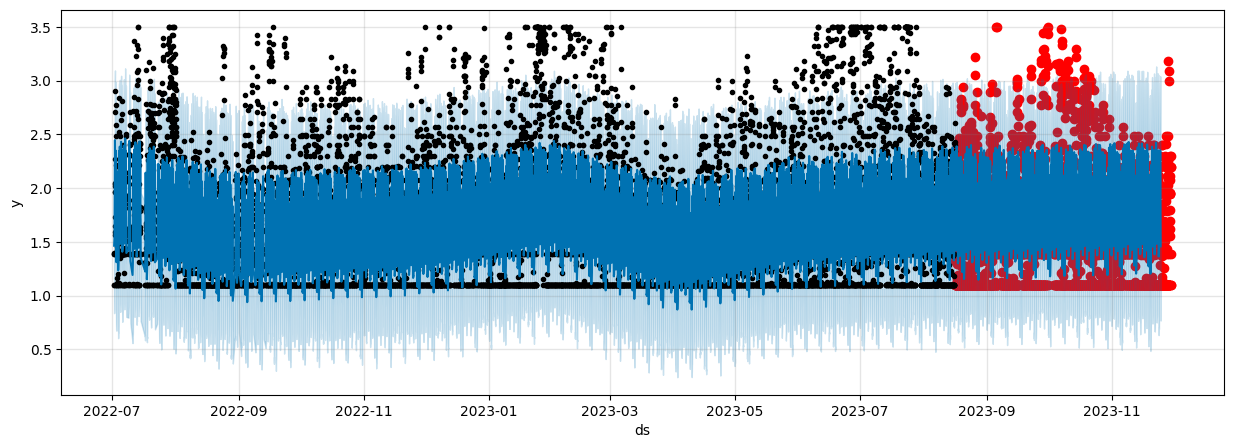

In [218]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test["ds"], test['y'], color='r')
fig = model.plot(forecast, ax=ax)

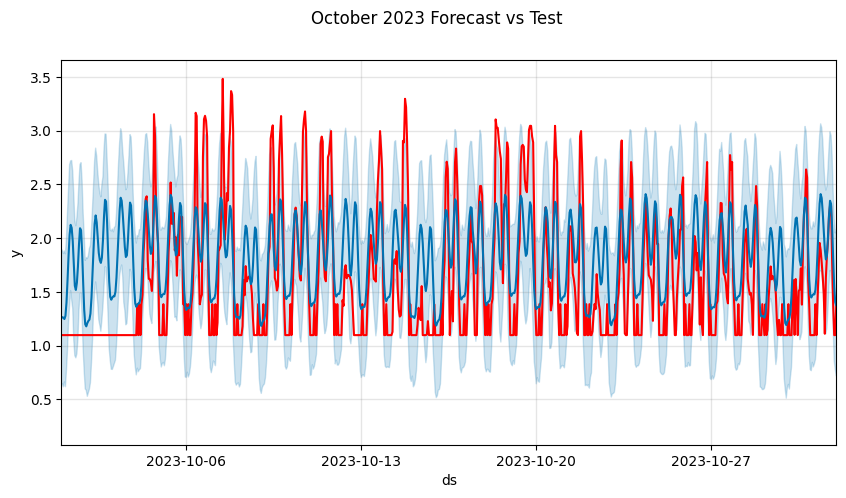

In [219]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(test["ds"], test['y'], color='r', label='Test')
fig = model.plot(forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2023-10-01 00:00:00'), pd.Timestamp('2023-11-01 00:00:00'))
plot = plt.suptitle('October 2023 Forecast vs Test')

In [220]:
predictions = forecast['yhat'].values[:len(test)]
mae, rmse, mape, mdape = calculate_metrics(np.expm1(test['y']), np.expm1(predictions))
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")

MAE: 3.2916070913217723, RMSE: 4.895324246385659, MAPE: 85.29824988495352, MdAPE: 59.8136754107629


In [221]:
plotPredictions(test['ds'], np.expm1(test['y']), np.expm1(predictions))

EMA Forecast MAE: 4.0520


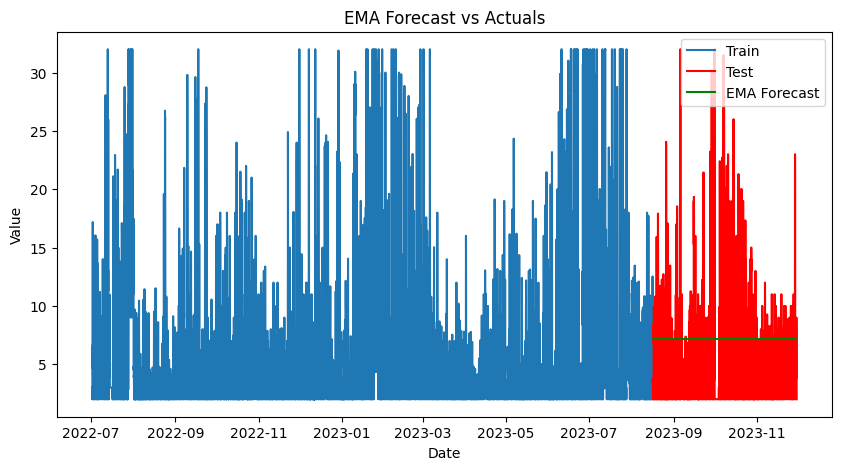

In [225]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
#df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()

def exponential_smoothing_average(values, span):
    ema = [sum(values[:span]) / span]

    multiplier = 2 / (span + 1)
    
    for value in values[span:]:
        ema.append((value - ema[-1]) * multiplier + ema[-1])
    
    return ema

span = 10
train_ema = exponential_smoothing_average(train['Demanda_kWh'].values, span)
ema_forecast = [train_ema[-1]] * len(test)

ema_mae = mean_absolute_error(test["Demanda_kWh"], ema_forecast)
print(f'EMA Forecast MAE: {ema_mae:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train['Date'], train['Demanda_kWh'], label='Train')
plt.plot(test['Date'], test['Demanda_kWh'], label='Test', color='r')
plt.plot(test['Date'], ema_forecast, label='EMA Forecast', color='g')
plt.title('EMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

plotPredictions(test["Date"], test["Demanda_kWh"], ema_forecast)


In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()

model_hw = ExponentialSmoothing(train['Demanda_kWh'], trend='add', seasonal='add', seasonal_periods=24).fit(smoothing_level=0.1, smoothing_trend=0.001, smoothing_seasonal=0.1, optimized=True)
ses_forecast = model_hw.forecast(len(test))

sema_mae = mean_absolute_error(test["Demanda_kWh"], ses_forecast)
mae, rmse, mape, mdape = calculate_metrics(test["Demanda_kWh"], ses_forecast)
print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MdAPE: {mdape}")
plotPredictions(test["Date"], test["Demanda_kWh"], ses_forecast)


MAE: 2.6245409191533415, RMSE: 4.188522831416655, MAPE: 58.914940715558785, MdAPE: nan


In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df["Demanda_kWh"] = df["Demanda_kWh"].apply(np.log1p)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()

model = SARIMAX(train['Demanda_kWh'], exog=train[['temperature_2m_C']], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
model_fit = model.fit(disp=False)

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [330]:
exog_future = test[['temperature_2m_C']]
forecast = model_fit.get_forecast(steps=len(test), exog=exog_future)
forecast_mean = forecast.predicted_mean

sarimax_mae = mean_absolute_error(np.expm1(test["Demanda_kWh"]), np.expm1(forecast_mean))
print(f'SARIMAX Forecast MAE: {sarimax_mae:.4f}')
plotPredictions(test["Date"], np.expm1(forecast_mean), np.expm1(test["Demanda_kWh"]))

SARIMAX Forecast MAE: 2.3313


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df["Demanda_kWh"] = df["Demanda_kWh"].apply(np.log1p)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
train = df.loc[:trainingSize].copy()
test = df.loc[trainingSize:].copy()

model = SARIMAX(train['Demanda_kWh'], order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
model_fit = model.fit(disp=False)


In [31]:
forecast = model_fit.get_forecast(steps=len(test))

forecast_mean = forecast.predicted_mean

sarimax_mae = mean_absolute_error(np.expm1(test["Demanda_kWh"]), np.expm1(forecast_mean))
print(f'SARIMAX Forecast MAE: {sarimax_mae:.4f}')
plotPredictions(test["Date"], np.expm1(forecast_mean), np.expm1(test["Demanda_kWh"]))

SARIMAX Forecast MAE: 2.2462


In [81]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/2010-2011 Solar home electricity data.csv', skiprows=1)
df["date"] = pd.to_datetime(df["date"])
df = df.drop(columns=["Postcode"], axis=1)
df = df[df["Customer"].isin([1, 2])]
df.head(5)

C:\Users\ssanchez\AppData\Local\Temp\ipykernel_5248\646531641.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Customer,Generator Capacity,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,3:00,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
0,1,3.78,GC,2010-07-01,0.303,0.471,0.083,0.121,0.361,0.079,...,0.495,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125
1,1,3.78,CL,2010-07-01,1.250,1.244,1.256,0.744,0.019,1.250,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075
2,1,3.78,GG,2010-07-01,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,3.78,GC,2010-07-02,0.116,0.346,0.122,0.079,0.120,0.107,...,0.262,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111
4,1,3.78,CL,2010-07-02,1.238,1.238,1.256,1.250,0.169,0.594,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088


In [82]:
horas_columnas = [col for col in df.columns if col not in ['Customer', 'Generator Capacity', 'Consumption Category', 'date']]
df_agrupado = df.groupby(['date', 'Consumption Category'])[horas_columnas].sum().reset_index()
df_agrupado.head()

,date,Consumption Category,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
0,2010-07-01,CL,1.250,1.244,1.256,0.744,0.019,1.250,0.069,0.000,...,0.000,0.000,1.912,0.000,0.000,0.000,0.000,0.000,0.000,1.075
1,2010-07-01,GC,0.388,0.613,0.165,0.240,0.466,0.167,0.261,0.155,...,1.278,1.399,0.808,0.826,0.690,0.513,0.581,0.431,0.385,0.304
2,2010-07-01,GG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2010-07-02,CL,1.238,1.238,1.256,1.250,0.169,0.594,0.688,0.000,...,0.000,0.000,1.889,0.000,0.000,0.000,0.000,0.000,0.000,1.088
4,2010-07-02,GC,0.282,0.516,0.194,0.228,0.200,0.247,0.413,0.267,...,2.234,2.959,2.435,2.315,2.068,1.773,1.927,1.677,1.664,1.672


In [83]:
df_filtrado = df_agrupado[df_agrupado['Consumption Category'] != 'CL']
df_gc = df_filtrado[df_filtrado['Consumption Category'] == 'GC']
df_gg = df_filtrado[df_filtrado['Consumption Category'] == 'GG']
df_gc_agrupado = df_gc.groupby('date')[horas_columnas].sum().reset_index()
df_gg_agrupado = df_gg.groupby('date')[horas_columnas].sum().reset_index()
df_resultado = df_gc_agrupado.copy()
#df_resultado[horas_columnas] = df_gc_agrupado[horas_columnas] - df_gg_agrupado[horas_columnas].fillna(0)
df_resultado[horas_columnas] = df_gc_agrupado[horas_columnas].fillna(0)
df_resultado

,date,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,4:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
0,2010-07-01,0.388,0.613,0.165,0.240,0.466,0.167,0.261,0.155,0.243,...,1.278,1.399,0.808,0.826,0.690,0.513,0.581,0.431,0.385,0.304
1,2010-07-02,0.282,0.516,0.194,0.228,0.200,0.247,0.413,0.267,0.152,...,2.234,2.959,2.435,2.315,2.068,1.773,1.927,1.677,1.664,1.672
2,2010-07-03,1.722,1.449,0.944,0.753,0.875,0.779,1.055,0.214,0.167,...,0.614,0.478,0.424,0.883,1.415,1.856,1.630,1.683,1.830,1.159
3,2010-07-04,0.546,0.473,0.279,0.577,0.325,0.284,0.267,0.300,0.520,...,1.509,1.353,1.534,2.010,2.062,1.887,1.578,1.620,1.877,0.765
4,2010-07-05,0.575,0.776,0.653,0.528,0.363,0.386,0.551,0.403,0.304,...,1.153,1.189,0.608,0.563,1.242,0.439,0.345,0.461,0.334,0.678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2011-06-26,0.712,0.221,0.253,0.190,0.205,0.192,0.771,0.212,0.248,...,0.686,0.786,0.445,0.602,0.742,0.690,0.353,0.258,0.144,0.233
361,2011-06-27,0.605,0.223,0.189,0.197,0.214,0.131,0.675,0.179,0.178,...,0.470,0.540,0.647,0.757,0.622,0.550,0.374,0.168,0.306,0.197
362,2011-06-28,0.683,1.158,1.221,1.164,0.831,0.774,1.170,0.731,0.268,...,0.544,0.451,0.505,0.590,0.533,0.918,0.622,0.373,0.279,0.385
363,2011-06-29,0.729,0.378,0.213,0.253,0.268,0.174,0.701,0.219,0.247,...,0.395,0.420,0.432,0.675,0.497,0.744,0.652,0.336,0.409,0.323


In [84]:
new_df = pd.melt(df_resultado, id_vars=['date'], value_vars=horas_columnas, var_name='time', value_name='Consumption')
new_df['time'] = new_df['time'] + ':00'
new_df['datetime'] = pd.to_datetime(new_df['date'].astype(str) + ' ' + new_df['time'])
final_df = new_df[['datetime', 'Consumption']]
final_df = final_df.sort_values(by='datetime').reset_index(drop=True)
final_df.rename(columns={'datetime': 'Date', 'Consumption': 'Demanda_kWh'}, inplace=True) 

In [85]:
final_df["Year"] = final_df["Date"].dt.year
final_df["Month"] = final_df["Date"].dt.month
final_df["Hour"] = final_df["Date"].dt.hour
final_df["DayOfWeek"] = final_df["Date"].dt.day_of_week
final_df["DayOfYear"] = final_df["Date"].dt.day_of_year
final_df["Day"] = final_df["Date"].dt.day

In [86]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

#Add isWeekend Column based in DayOfTheWeek Value
final_df["isWeekend"] = final_df["DayOfWeek"].isin([5, 6])
cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

#Encode cyclical fields using sin/cos transformation
merged_df = cyclical_encoding(final_df, cycle_lengths, cols)

merged_df.head(3)

,Date,Demanda_kWh,Year,Month,Hour,DayOfWeek,DayOfYear,Day,isWeekend,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,DayOfYear_sin,DayOfYear_cos
0,2010-07-01 00:00:00,0.304,2010,7,0,3,182,1,False,-0.2588,0.9659,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
1,2010-07-01 00:30:00,0.388,2010,7,0,3,182,1,False,-0.2588,0.9659,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
2,2010-07-01 01:00:00,0.613,2010,7,1,3,182,1,False,0.0000,1.0000,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997


In [87]:
final_df.to_csv("../data/newData.csv", index=None)
final_df.head(5)

,Date,Demanda_kWh,Year,Month,Hour,DayOfWeek,DayOfYear,Day,isWeekend,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,DayOfYear_sin,DayOfYear_cos
0,2010-07-01 00:00:00,0.304,2010,7,0,3,182,1,False,-0.2588,0.9659,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
1,2010-07-01 00:30:00,0.388,2010,7,0,3,182,1,False,-0.2588,0.9659,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
2,2010-07-01 01:00:00,0.613,2010,7,1,3,182,1,False,0.0000,1.0000,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
3,2010-07-01 01:30:00,0.165,2010,7,1,3,182,1,False,0.0000,1.0000,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997
4,2010-07-01 02:00:00,0.240,2010,7,2,3,182,1,False,0.2588,0.9659,0.9749,-0.2225,0.0,-1.0,0.0258,-0.9997


In [88]:
# Plots a time series curve
import plotly.graph_objects as go
def grafico_zoom(df_x, df_y, title, yaxis_title, filename):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))

    fig.update_layout(
        title=title,  
        xaxis_title="Date",
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    # Save the image with the specified filename
    fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

grafico_zoom(final_df["Date"], final_df["Demanda_kWh"], "Gráfico de Demanda", "Demanda [kWh]", "")